**Lecture 3 Notebook**
(inspired by CS109 exercise)

Here we illustrate data scraping with BeautifulSoup and data storage/manipulation with Pandas.

First, we set up the environment:

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML

Next, we import the necessary libraries:

In [3]:
import numpy as np
#import matplotlib.pyplot as plt
import pandas as pd

import requests
from bs4 import BeautifulSoup
from IPython.display import HTML

As our illustrative data set, we will work on the Nobel Prizes data set. We will get it from the Nobel Prizes website, using requests.

In [4]:
url = "https://www.nobelprize.org/prizes/lists/all-nobel-prizes/"
r = requests.get(url)

Let's take a look at the raw data.

In [5]:
r.text

'\t<!DOCTYPE html>\n\n\t<html lang="en-US" class="no-js">\n\n\t<head>\n\n\t\t<meta charset="UTF-8"><script type="text/javascript">(window.NREUM||(NREUM={})).loader_config={licenseKey:"06ce85f426",applicationID:"929633794"};window.NREUM||(NREUM={}),__nr_require=function(e,t,n){function r(n){if(!t[n]){var i=t[n]={exports:{}};e[n][0].call(i.exports,function(t){var i=e[n][1][t];return r(i||t)},i,i.exports)}return t[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var i=0;i<n.length;i++)r(n[i]);return r}({1:[function(e,t,n){function r(){}function i(e,t,n){return function(){return o(e,[u.now()].concat(c(arguments)),t?null:this,n),t?void 0:this}}var o=e("handle"),a=e(6),c=e(7),f=e("ee").get("tracer"),u=e("loader"),s=NREUM;"undefined"==typeof window.newrelic&&(newrelic=s);var d=["setPageViewName","setCustomAttribute","setErrorHandler","finished","addToTrace","inlineHit","addRelease"],p="api-",l=p+"ixn-";a(d,function(e,t){s[t]=i(p+t,!0,"api")}),s.addPageAction=i(p+"addPageA

It's html so we process it using BeautifulSoup, with the html parser. Note that there are other parsers, some for more specialized html parsing. See https://www.crummy.com/software/BeautifulSoup/bs4/doc/#differences-between-parsers for more.

In [6]:
soup = BeautifulSoup(r.text, 'html.parser')

Let's take a look at the source code.

In [7]:
print(soup.prettify()[:700])

<!DOCTYPE html>
<html class="no-js" lang="en-US">
 <head>
  <meta charset="utf-8"/>
  <script type="text/javascript">
   (window.NREUM||(NREUM={})).loader_config={licenseKey:"06ce85f426",applicationID:"929633794"};window.NREUM||(NREUM={}),__nr_require=function(e,t,n){function r(n){if(!t[n]){var i=t[n]={exports:{}};e[n][0].call(i.exports,function(t){var i=e[n][1][t];return r(i||t)},i,i.exports)}return t[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var i=0;i<n.length;i++)r(n[i]);return r}({1:[function(e,t,n){function r(){}function i(e,t,n){return function(){return o(e,[u.now()].concat(c(arguments)),t?null:this,n),t?void 0:this}}var o=e("handle"),a=e(6),c=e(7),f=e("ee")


We can mine the soup object in a number of ways.

* select_one
* find_all
* soup.a, soup.p, etc.
* etc


In [15]:
soup.select_one('title').text

'All Nobel Prizes'

In [ ]:
award_nodes = soup.select('.by_year')
len(award_nodes)

641

Let's take a look at one of those 641.

In [ ]:
award_node = award_nodes[200]

In [ ]:
award_node

<div class="by_year">
<h3><a href="https://www.nobelprize.org/nobel_prizes/chemistry/laureates/1985/">The Nobel Prize in Chemistry 1985</a></h3>
<p><a href="https://www.nobelprize.org/nobel_prizes/chemistry/laureates/1985/hauptman-facts.html">Herbert A. Hauptman</a> and <a href="https://www.nobelprize.org/nobel_prizes/chemistry/laureates/1985/karle-facts.html">Jerome Karle</a><br/>
“for their outstanding achievements in the development of direct methods for the determination of crystal structures”</p>
</div>

Now we proceed to extract the title of the award, year, recipients, and motivation for the award.

To do that we pay particular attention to the html tags and text structure.

The title and year are simple, but note that the bs4 object is a tree, and eventually as we process the nodes we will get to an empty node.

In [ ]:
def get_award_title(award_node):
    award_node = award_node.select_one('h3')
    if not award_node:
        return None
    return award_node.text[:-5]

In [ ]:
def get_award_year(award_node):
    award_node = award_node.select_one('h3')
    if not award_node:
        return None
    return award_node.text[-4:]

Processing the recipients and the motivation comes next. 

The recipients are relatively easy to grab:

In [ ]:
def get_recipients(award_node):
    return [node.text for node in award_node.select('p a')]

The motivation comes after a <br> tag, 
a known weakeness for bs4. For now we will leave it messy 
(includes the names)

In [ ]:
award_node.select_one('p').text

In [ ]:
award_node.select_one('p').text
print(json.dumps(award_node.select_one('p').text))

In [ ]:
def get_award_motivation(award_node):
    award_node = award_node.select_one('p')
    if not award_node:
        return None
    return award_node.text
    

Now we iterate over the whole soup object and create a dictionary.

In [ ]:
awards = []
for award_node in soup.select('.by_year'):
    recipients = get_recipients(award_node)
    awards.append(dict(
        title=get_award_title(award_node),
        year=get_award_year(award_node),
        recipients=recipients,
        num_recipients=len(recipients),
        motivation=get_award_motivation(award_node)
    ))

In [ ]:
awards

**Pandas Time!**

Create a dataframe

In [ ]:
df_awards_raw = pd.DataFrame(awards)

In [ ]:
df_awards_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           640 non-null    object
 1   year            640 non-null    object
 2   recipients      641 non-null    object
 3   num_recipients  641 non-null    int64 
 4   motivation      640 non-null    object
dtypes: int64(1), object(4)
memory usage: 25.2+ KB


In [ ]:
df_awards_raw.num_recipients.value_counts()


1     348
2     140
3     101
0      50
14      1
5       1
Name: num_recipients, dtype: int64

Some weirdeness in there.


In [ ]:
df_awards_raw[df_awards_raw.num_recipients == 0]


,title,year,recipients,num_recipients,motivation
1,,2018,[],0,None
281,The Nobel Peace Prize,1972,[],0,No Nobel Prize was awarded this year. The priz...
310,The Nobel Peace Prize,1967,[],0,No Nobel Prize was awarded this year. The priz...
315,The Nobel Peace Prize,1966,[],0,No Nobel Prize was awarded this year. The priz...
365,The Nobel Peace Prize,1956,[],0,No Nobel Prize was awarded this year. The priz...
370,The Nobel Peace Prize,1955,[],0,No Nobel Prize was awarded this year. The priz...
405,The Nobel Peace Prize,1948,[],0,No Nobel Prize was awarded this year. The priz...
429,The Nobel Prize in Literature,1943,[],0,No Nobel Prize was awarded this year. The priz...
430,The Nobel Peace Prize,1943,[],0,No Nobel Prize was awarded this year. The priz...
431,The Nobel Prize in Physics,1942,[],0,No Nobel Prize was awarded this year. The priz...


So, that's a problem. What else?

In [ ]:
df_awards_raw[df_awards_raw.title.isnull()].head()


,title,year,recipients,num_recipients,motivation
2,None,None,"[Arthur Ashkin, Gérard Mourou, Donna Strickland]",3,“for groundbreaking inventions in the field of...


In [ ]:
df_awards_nonull = df_awards_nonull[-df_awards_nonull.title.isnull()]
df_awards_nonull = df_awards_nonull[-df_awards_nonull.year.isnull()]
df_awards_nonull = df_awards_nonull[-df_awards_nonull.recipients.isnull()]

df_awards_nonull.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 586 entries, 0 to 640
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           586 non-null    object
 1   year            586 non-null    object
 2   recipients      586 non-null    object
 3   num_recipients  586 non-null    int64 
 4   motivation      586 non-null    object
dtypes: int64(1), object(4)
memory usage: 27.5+ KB


Now that we have a non-messy table, let's look at the data and see if there are any outlier issues.

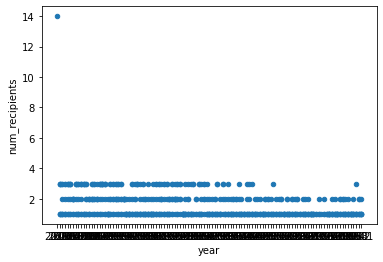

In [ ]:
df_awards_nonull.plot.scatter(x='year', y='num_recipients')


Let's aggregate by year.

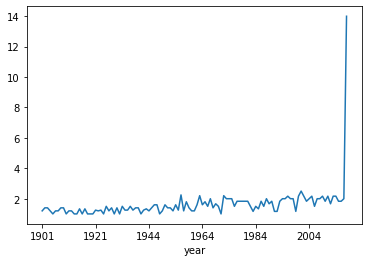

In [ ]:
df_awards_nonull.groupby('year').num_recipients.mean().plot.line()


In [ ]:
df_awards_nonull[df_awards_nonull.num_recipients>5]

,title,year,recipients,num_recipients,motivation
0,,2019,"[James Peebles, Michel Mayor, Didier Queloz, J...",14,“for contributions to our understanding of the...


Go to google to check this.